In [12]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("Environment configured")

Environment configured


# YOLOv8 Facial Expression Recognition (FER) - Google Colab Training

Train a **YOLOv8-cls FER classifier** using **Balanced AffectNet + Custom Dataset**.

## Project: Facial Expression Follower Robot

**Goal:** Classify facial expressions into 5 emotions for robot control
- **Happy** → Robot moves forward
- **Sad** → Robot turns right  
- **Angry** → Robot moves backward
- **Surprised** → Robot turns left
- **Neutral** → Robot stops

## 🔧 Google Colab Setup Instructions

### **Step 1: Enable GPU**
Runtime → Change runtime type → **GPU (T4 or V100)**

### **Step 2: Mount Google Drive**
1. Run the cell below to mount your Google Drive
2. Upload your datasets to Google Drive:
   ```
   My Drive/
   ├── balanced-affectnet/        (Download and upload)
   │   ├── train/
   │   ├── val/
   │   └── test/
   └── fer-custom-dataset/         (Your custom images)
       ├── angry/
       ├── happy/
       ├── neutral/
       ├── sad/
       └── surprised/
   ```

### **Step 3: Dataset Sources**

**Balanced AffectNet:**
- Download from: https://www.kaggle.com/datasets/dollyprajapati182/balanced-affectnet
- Upload to Google Drive: `My Drive/balanced-affectnet/`

**Custom Dataset (Optional):**
- Prepare your custom images (100-200 per class, 224×224 RGB)
- Upload to: `My Drive/fer-custom-dataset/`

## Expected Training Time
~20-30 minutes total on Colab GPU

## 2️⃣ Check GPU Availability

## 1️⃣ Mount Google Drive

In [13]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("✓ Google Drive mounted successfully")
print("\nYour Drive is accessible at: /content/drive/MyDrive/")
print("\nMake sure you have uploaded:")
print("  • balanced-affectnet/ (download from Kaggle)")
print("  • fer-custom-dataset/ (your custom images)")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully

Your Drive is accessible at: /content/drive/MyDrive/

Make sure you have uploaded:
  • balanced-affectnet/ (download from Kaggle)
  • fer-custom-dataset/ (your custom images)


In [ ]:
# Check GPU availability
import torch

print("=" * 60)
print("GPU CHECK")
print("=" * 60)
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print("\nGPU is ready for training!")
else:
    print("\nNo GPU found - training will be slower")

print("=" * 60)

GPU CHECK
PyTorch Version: 2.9.0+cu126
CUDA Available: True
GPU Device: Tesla T4
GPU Memory: 15.8 GB

GPU is ready for training!


## 3️⃣ Import Required Libraries

In [ ]:
# Install ultralytics (YOLOv8)
!pip install ultralytics -q

# Import libraries
import os
import shutil
import numpy as np
from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from PIL import Image

# YOLOv8
from ultralytics import YOLO

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✓ All libraries imported successfully


# Kaggle API

In [ ]:
# Install Kaggle API
!pip install -q kaggle

# Upload your kaggle.json file
from google.colab import files
import os
import json

print("=" * 60)
print("KAGGLE API SETUP")
print("=" * 60)

kaggle_dir = os.path.expanduser('~/.kaggle')
kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')

# Path to kaggle.json in Google Drive (update if different)
drive_kaggle_json = '/content/drive/MyDrive/AUPP/ICT_361_Robotics/Final_Project/kaggle.json'

if os.path.exists(kaggle_json_path):
    print("Kaggle API credentials already configured")
elif os.path.exists(drive_kaggle_json):
    # Copy from Google Drive
    print(f"Found kaggle.json in Google Drive: {drive_kaggle_json}")
    os.makedirs(kaggle_dir, exist_ok=True)
    shutil.copy2(drive_kaggle_json, kaggle_json_path)
    os.chmod(kaggle_json_path, 0o600)
    print(f"Kaggle credentials configured from Google Drive")
else:
    print("\nPlease upload your kaggle.json file:")

    # Upload kaggle.json
    uploaded = files.upload()

    # Create .kaggle directory
    os.makedirs(kaggle_dir, exist_ok=True)

    # Move kaggle.json to ~/.kaggle/
    for filename in uploaded.keys():
        if filename == 'kaggle.json':
            with open(kaggle_json_path, 'w') as f:
                f.write(uploaded[filename].decode('utf-8'))

            # Set permissions
            os.chmod(kaggle_json_path, 0o600)
            print(f"\nKaggle credentials saved to {kaggle_json_path}")
            break

print("=" * 60)

KAGGLE API SETUP
Found kaggle.json in Google Drive: /content/drive/MyDrive/AUPP/ICT_361_Robotics/Final_Project/kaggle.json
Kaggle credentials configured from Google Drive


# Download AffectNet Dataset

In [ ]:
# Download Balanced AffectNet dataset from Kaggle
print("=" * 60)
print("DOWNLOADING BALANCED AFFECTNET FROM KAGGLE")
print("=" * 60)

# Create directory for dataset
dataset_dir = '/content/datasets'
os.makedirs(dataset_dir, exist_ok=True)

# Download the dataset
print("\nDownloading dataset...")
print("   Dataset: dollyprajapati182/balanced-affectnet")

!kaggle datasets download -d dollyprajapati182/balanced-affectnet -p {dataset_dir} --unzip

print("\nDownload complete!")

# Verify download
affectnet_path = os.path.join(dataset_dir, 'balanced-affectnet')
if os.path.exists(affectnet_path):
    print(f"✓ Dataset extracted to: {affectnet_path}")

    # List contents
    print("\nDataset structure:")
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(affectnet_path, split)
        if os.path.exists(split_path):
            folders = os.listdir(split_path)
            print(f"  {split}/: {folders}")
else:
    # Check if files are in dataset_dir directly
    print(f"\nDataset might be in: {dataset_dir}")
    print("Contents:")
    for item in os.listdir(dataset_dir)[:10]:
        print(f"  • {item}")

print("=" * 60)

DOWNLOADING BALANCED AFFECTNET FROM KAGGLE

   Dataset: dollyprajapati182/balanced-affectnet
Dataset URL: https://www.kaggle.com/datasets/dollyprajapati182/balanced-affectnet
License(s): unknown
 55% 149M/273M [00:00<00:00, 1.55GB/s]
100% 273M/273M [00:00<00:00, 999MB/s] 

Download complete!

Dataset might be in: /content/datasets
Contents:
  • train
  • val
  • test


## 4️⃣ Configuration & Dataset Path

In [ ]:
# ============== CONFIGURATION ==============
IMG_SIZE = 96          # YOLOv8 input size (resize from 75x75)
BATCH_SIZE = 16         # Batch size for training
EPOCHS = 50             # Number of epochs (with early stopping)
LEARNING_RATE = 0.001   # Learning rate
NUM_CLASSES = 5         # 5 emotion classes
MAX_AFFECTNET_PER_CLASS = 1200

# Target emotion classes for robot control
CLASS_NAMES = ['angry', 'happy', 'neutral', 'sad', 'surprised']

# Balanced AffectNet folder mapping (case-insensitive)
AFFECTNET_MAPPING = {
    'anger': 'angry',
    'happy': 'happy',
    'neutral': 'neutral',
    'sad': 'sad',
    'surprise': 'surprised',
    # Skip these:
    'contempt': None,
    'disgust': None,
    'fear': None,
}

# ============== DATASET PATHS (Google Drive) ==============
# Balanced AffectNet from Google Drive
AFFECTNET_DIR = '/content/datasets'

# Custom dataset from Google Drive
# Set to None if not using custom data
CUSTOM_DATA_DIR = '/content/drive/MyDrive/AUPP/ICT_361_Robotics/Final_Project/custom_emotions'  # Change this path!

# Set to True to use custom dataset
USE_CUSTOM_DATA = True

# Output directory (Colab working directory)
OUTPUT_DIR = '/content/output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("=" * 60)
print("CONFIGURATION - YOLOv8 CLASSIFICATION")
print("=" * 60)
print(f"Model: YOLOv8n-cls (nano classifier)")
print(f"Image Size: {IMG_SIZE}×{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Classes: {CLASS_NAMES}")
print(f"\nDATASETS:")
print(f"  • AffectNet: {AFFECTNET_DIR}")
print(f"  • Custom: {CUSTOM_DATA_DIR if USE_CUSTOM_DATA else 'Not used'}")
print("=" * 60)

CONFIGURATION - YOLOv8 CLASSIFICATION
Model: YOLOv8n-cls (nano classifier)
Image Size: 96×96
Batch Size: 16
Epochs: 50
Classes: ['angry', 'happy', 'neutral', 'sad', 'surprised']

DATASETS:
  • AffectNet: /content/datasets
  • Custom: /content/drive/MyDrive/AUPP/ICT_361_Robotics/Final_Project/custom_emotions


## 5️⃣ Load and Check Datasets

### How to Add Your Custom Dataset to Google Drive:

**Step 1: Prepare your dataset structure**
```
fer-custom-dataset/
├── angry/     (207 images, 224x224 RGB)
├── happy/     (200 images, 224x224 RGB)
├── neutral/   (245 images, 224x224 RGB)
├── sad/       (170 images, 224x224 RGB)
└── surprised/ (201 images, 224x224 RGB)
```

**Step 2: Upload to Google Drive**
1. Go to Google Drive: https://drive.google.com
2. Upload the `fer-custom-dataset` folder to `My Drive/`
3. Upload the `balanced-affectnet` folder to `My Drive/`

**Step 3: Verify paths**
- The notebook will automatically check if datasets exist
- Make sure paths match your Google Drive structure

In [14]:
# Check all datasets
print("=" * 60)
print("CHECKING DATASETS")
print("=" * 60)

# Check AffectNet dataset (downloaded via Kaggle API)
print("1️⃣ BALANCED AFFECTNET (from Kaggle):")
print("-" * 40)

affectnet_stats = {'train': {}, 'val': {}, 'test': {}}

if os.path.exists(AFFECTNET_DIR):
    print(f"✓ Found at: {AFFECTNET_DIR}")
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(AFFECTNET_DIR, split)
        if os.path.exists(split_dir):
            for folder in os.listdir(split_dir):
                folder_path = os.path.join(split_dir, folder)
                if os.path.isdir(folder_path):
                    target_class = AFFECTNET_MAPPING.get(folder.lower())
                    if target_class:
                        count = len([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
                        affectnet_stats[split][target_class] = count

    for split in ['train', 'val', 'test']:
        total = sum(affectnet_stats[split].values())
        print(f"   {split}: {total} images")
else:
    print(f"NOT FOUND at: {AFFECTNET_DIR}")
    print("   → Make sure the download cell completed successfully")
    print("   → Check if dataset is at /content/datasets/")
    if os.path.exists('/content/datasets'):
        print("   → Contents of /content/datasets/:")
        for item in os.listdir('/content/datasets')[:10]:
            print(f"      • {item}")

# Check Custom dataset (from Google Drive)
print("\n" + "-" * 40)
print("2️⃣ CUSTOM DATASET (from Google Drive):")
print("-" * 40)

custom_stats = {}

if USE_CUSTOM_DATA and CUSTOM_DATA_DIR:
    if os.path.exists(CUSTOM_DATA_DIR):
        print(f"Found at: {CUSTOM_DATA_DIR}")

        # Check structure - might be flat or have train/val/test
        has_splits = os.path.exists(os.path.join(CUSTOM_DATA_DIR, 'train'))

        if has_splits:
            print("   Structure: train/val/test folders")
            for split in ['train', 'val', 'test']:
                split_dir = os.path.join(CUSTOM_DATA_DIR, split)
                if os.path.exists(split_dir):
                    for class_name in CLASS_NAMES:
                        class_dir = os.path.join(split_dir, class_name)
                        if os.path.exists(class_dir):
                            count = len([f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
                            custom_stats[f"{split}_{class_name}"] = count
                            print(f"   {split}/{class_name}: {count} images")
        else:
            print("   Structure: flat (class folders only)")
            for class_name in CLASS_NAMES:
                class_dir = os.path.join(CUSTOM_DATA_DIR, class_name)
                if os.path.exists(class_dir):
                    count = len([f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
                    custom_stats[class_name] = count
                    print(f"   {class_name}: {count} images")
                else:
                    print(f"   {class_name}: not found")

        total_custom = sum(custom_stats.values())
        print(f"\n   Total custom images: {total_custom}")
    else:
        print(f"NOT FOUND at: {CUSTOM_DATA_DIR}")
        print("   → Upload your custom dataset to Google Drive")
        print("   → Or set USE_CUSTOM_DATA = False to skip")
else:
    print("   Skipped (USE_CUSTOM_DATA = False)")

print("\n" + "=" * 60)

CHECKING DATASETS
1️⃣ BALANCED AFFECTNET (from Kaggle):
----------------------------------------
✓ Found at: /content/datasets
   train: 17627 images
   val: 4556 images
   test: 2546 images

----------------------------------------
2️⃣ CUSTOM DATASET (from Google Drive):
----------------------------------------
Found at: /content/drive/MyDrive/AUPP/ICT_361_Robotics/Final_Project/custom_emotions
   Structure: flat (class folders only)
   angry: 207 images
   happy: 200 images
   neutral: 245 images
   sad: 169 images
   surprised: 200 images

   Total custom images: 1021



### Visualize Sample Images

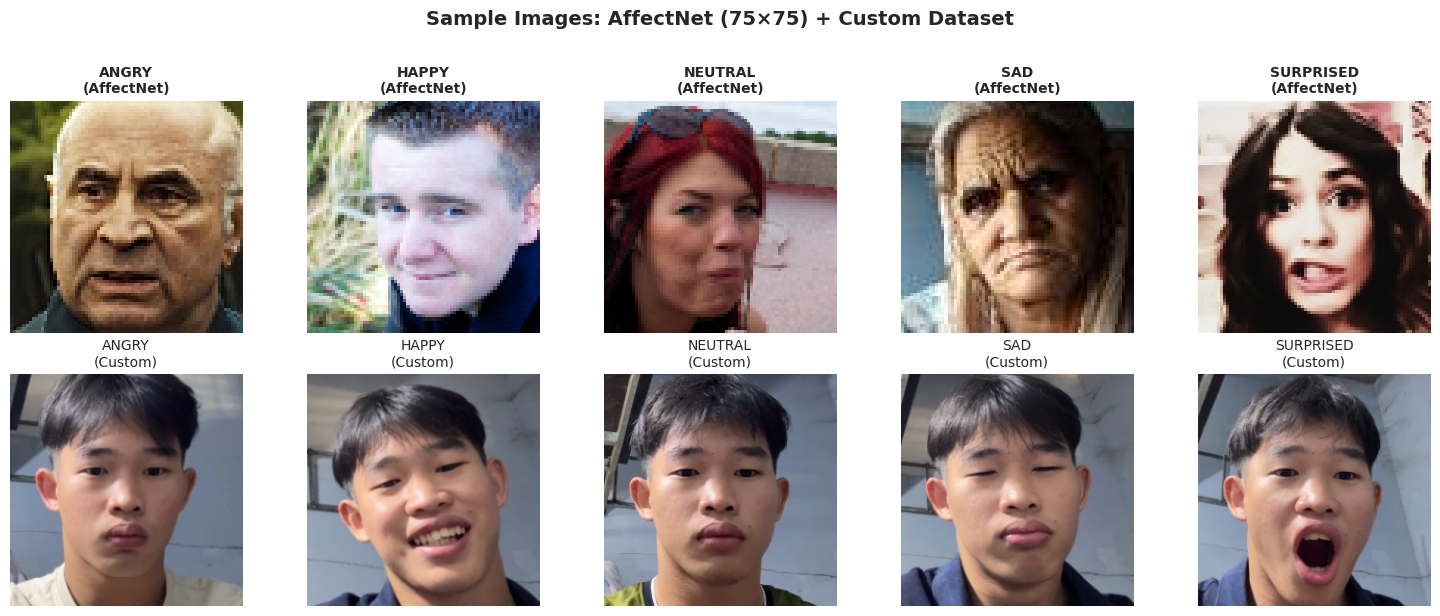

In [15]:
# Display sample images from both datasets
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Map AffectNet folder names to our class names
FOLDER_TO_CLASS = {
    'Anger': 'angry',
    'Happy': 'happy',
    'Neutral': 'neutral',
    'Sad': 'sad',
    'Surprise': 'surprised'
}

train_dir = os.path.join(AFFECTNET_DIR, 'train')

for idx, (folder_name, class_name) in enumerate(FOLDER_TO_CLASS.items()):
    class_path = os.path.join(train_dir, folder_name)

    if os.path.exists(class_path):
        img_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        if len(img_files) >= 2:
            # First sample (AffectNet)
            img_path = os.path.join(class_path, img_files[0])
            img = Image.open(img_path)
            axes[0, idx].imshow(img)
            axes[0, idx].set_title(f'{class_name.upper()}\n(AffectNet)', fontsize=10, fontweight='bold')
            axes[0, idx].axis('off')

            # Second sample - try custom dataset
            custom_class_dir = os.path.join(CUSTOM_DATA_DIR, class_name) if USE_CUSTOM_DATA else None
            if custom_class_dir and os.path.exists(custom_class_dir):
                custom_files = [f for f in os.listdir(custom_class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
                if custom_files:
                    img_path2 = os.path.join(custom_class_dir, custom_files[0])
                    img2 = Image.open(img_path2)
                    axes[1, idx].imshow(img2)
                    axes[1, idx].set_title(f'{class_name.upper()}\n(Custom)', fontsize=10)
                    axes[1, idx].axis('off')
                else:
                    axes[1, idx].text(0.5, 0.5, 'No custom\nimages', ha='center', va='center')
                    axes[1, idx].axis('off')
            else:
                img_path2 = os.path.join(class_path, img_files[1])
                img2 = Image.open(img_path2)
                axes[1, idx].imshow(img2)
                axes[1, idx].set_title(f'{class_name.upper()}\n(AffectNet 2)', fontsize=10)
                axes[1, idx].axis('off')
    else:
        axes[0, idx].text(0.5, 0.5, f'{folder_name}\nNot Found', ha='center', va='center')
        axes[0, idx].axis('off')
        axes[1, idx].axis('off')

plt.suptitle('Sample Images: AffectNet (75×75) + Custom Dataset', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6️⃣ Data Preprocessing & Augmentation

In [16]:
# Prepare MERGED dataset for YOLOv8 (AffectNet + Custom)
print("=" * 60)
print("PREPARING MERGED DATASET FOR YOLOV8")
print("=" * 60)

# Map AffectNet folder names to our classes
FOLDER_MAPPING = {
    'Anger': 'angry', 'anger': 'angry',
    'Happy': 'happy', 'happy': 'happy',
    'Neutral': 'neutral', 'neutral': 'neutral',
    'Sad': 'sad', 'sad': 'sad',
    'Surprise': 'surprised', 'surprise': 'surprised', 'surprised': 'surprised',
}

# Create YOLOv8 dataset directory
yolo_dataset_dir = os.path.join(OUTPUT_DIR, 'yolo_fer_dataset')
yolo_train_dir = os.path.join(yolo_dataset_dir, 'train')
yolo_val_dir = os.path.join(yolo_dataset_dir, 'val')
yolo_test_dir = os.path.join(yolo_dataset_dir, 'test')

# Create directories
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(yolo_train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(yolo_val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(yolo_test_dir, class_name), exist_ok=True)

stats = {'affectnet': {'train': {}, 'val': {}, 'test': {}},
         'custom': {'train': {}, 'val': {}, 'test': {}}}

# ============== PROCESS AFFECTNET (CORRECTLY LIMITED) ==============
print("\nProcessing AffectNet dataset (CORRECTLY LIMITED)...")
print(f"   Limiting to {MAX_AFFECTNET_PER_CLASS} images TOTAL per class (not per split)")
print(f"   Split ratio: 70% train, 20% val, 10% test")

import random
random.seed(42)  # For reproducibility

# Process each class separately to ensure proper limiting
for class_name in CLASS_NAMES:
    # Collect ALL images for this class across all splits
    all_class_images = []

    for split in ['train', 'val', 'test']:
        src_split_dir = os.path.join(AFFECTNET_DIR, split)
        if not os.path.exists(src_split_dir):
            continue

        for folder_name in os.listdir(src_split_dir):
            folder_path = os.path.join(src_split_dir, folder_name)
            if not os.path.isdir(folder_path):
                continue

            target_class = FOLDER_MAPPING.get(folder_name)
            if target_class != class_name:
                continue

            # Get all images from this folder
            img_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                        if f.endswith(('.png', '.jpg', '.jpeg'))]
            all_class_images.extend(img_files)

    # LIMIT TOTAL images per class
    if len(all_class_images) > MAX_AFFECTNET_PER_CLASS:
        all_class_images = random.sample(all_class_images, MAX_AFFECTNET_PER_CLASS)

    # Shuffle and split 70/20/10
    random.shuffle(all_class_images)
    n_total = len(all_class_images)
    n_train = int(n_total * 0.70)
    n_val = int(n_total * 0.20)

    split_images = {
        'train': all_class_images[:n_train],
        'val': all_class_images[n_train:n_train+n_val],
        'test': all_class_images[n_train+n_val:]
    }

    # Copy images to destination
    for split, img_paths in split_images.items():
        if split == 'train':
            dst_dir = os.path.join(yolo_train_dir, class_name)
        elif split == 'val':
            dst_dir = os.path.join(yolo_val_dir, class_name)
        else:
            dst_dir = os.path.join(yolo_test_dir, class_name)

        count = 0
        for src_path in img_paths:
            dst_path = os.path.join(dst_dir, f"affectnet_{class_name}_{split}_{count:05d}.jpg")

            try:
                img = cv2.imread(src_path)
                if img is None:
                    continue
                img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(dst_path, img_resized)
                count += 1
            except:
                continue

        stats['affectnet'][split][class_name] = count

# Print split totals
for split in ['train', 'val', 'test']:
    total = sum(stats['affectnet'][split].values())
    print(f"  ✓ {split}: {total} images")

# ============== PROCESS CUSTOM DATASET (ALL IMAGES) ==============
if USE_CUSTOM_DATA and os.path.exists(CUSTOM_DATA_DIR):
    print("\nProcessing Custom dataset (ALL IMAGES - PRIORITY)...")

    # Check if custom has train/val/test or flat structure
    has_splits = os.path.exists(os.path.join(CUSTOM_DATA_DIR, 'train'))

    if has_splits:
        # Custom dataset has train/val/test structure
        for split in ['train', 'val', 'test']:
            split_dir = os.path.join(CUSTOM_DATA_DIR, split)
            if not os.path.exists(split_dir):
                continue

            for class_name in CLASS_NAMES:
                class_dir = os.path.join(split_dir, class_name)
                if not os.path.exists(class_dir):
                    continue

                if split == 'train':
                    dst_dir = os.path.join(yolo_train_dir, class_name)
                elif split == 'val':
                    dst_dir = os.path.join(yolo_val_dir, class_name)
                else:
                    dst_dir = os.path.join(yolo_test_dir, class_name)

                # USE ALL CUSTOM IMAGES
                img_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
                count = 0

                for img_file in img_files:
                    src_path = os.path.join(class_dir, img_file)
                    dst_path = os.path.join(dst_dir, f"custom_{class_name}_{split}_{count:05d}.jpg")

                    try:
                        img = cv2.imread(src_path)
                        if img is None:
                            continue
                        # Resize if needed
                        if img.shape[0] != IMG_SIZE or img.shape[1] != IMG_SIZE:
                            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
                        cv2.imwrite(dst_path, img)
                        count += 1
                    except:
                        continue

                stats['custom'][split][class_name] = count

            total = sum(stats['custom'][split].values())
            print(f"  {split}: {total} images (ALL custom images included)")
    else:
        # Flat structure - split 70/15/15 for train/val/test
        print("  (Flat structure detected - splitting 70/15/15)")

        for class_name in CLASS_NAMES:
            class_dir = os.path.join(CUSTOM_DATA_DIR, class_name)
            if not os.path.exists(class_dir):
                continue

            # USE ALL CUSTOM IMAGES
            img_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

            # Shuffle and split
            random.shuffle(img_files)

            n_total = len(img_files)
            n_train = int(n_total * 0.70)
            n_val = int(n_total * 0.15)

            splits_files = {
                'train': img_files[:n_train],
                'val': img_files[n_train:n_train+n_val],
                'test': img_files[n_train+n_val:]
            }

            for split, files in splits_files.items():
                if split == 'train':
                    dst_dir = os.path.join(yolo_train_dir, class_name)
                elif split == 'val':
                    dst_dir = os.path.join(yolo_val_dir, class_name)
                else:
                    dst_dir = os.path.join(yolo_test_dir, class_name)

                count = 0
                for img_file in files:
                    src_path = os.path.join(class_dir, img_file)
                    dst_path = os.path.join(dst_dir, f"custom_{class_name}_{split}_{count:05d}.jpg")

                    try:
                        img = cv2.imread(src_path)
                        if img is None:
                            continue
                        if img.shape[0] != IMG_SIZE or img.shape[1] != IMG_SIZE:
                            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
                        cv2.imwrite(dst_path, img)
                        count += 1
                    except:
                        continue

                stats['custom'][split][class_name] = stats['custom'][split].get(class_name, 0) + count

        for split in ['train', 'val', 'test']:
            total = sum(stats['custom'][split].values())
            print(f"  ✓ {split}: {total} images (ALL custom images)")
else:
    print("\nERROR: Custom dataset not found!")
    print(f"   Expected at: {CUSTOM_DATA_DIR}")
    print("   Please upload your custom dataset to Kaggle")

# ============== PRINT SUMMARY ==============
print("\n" + "=" * 60)
print("MERGED DATASET SUMMARY")
print("=" * 60)

for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()}:")
    for class_name in CLASS_NAMES:
        affectnet_count = stats['affectnet'][split].get(class_name, 0)
        custom_count = stats['custom'][split].get(class_name, 0)
        total = affectnet_count + custom_count
        print(f"  {class_name:12s}: {total:5d} (AffectNet: {affectnet_count}, Custom: {custom_count})")

# Grand totals
total_affectnet = sum(sum(stats['affectnet'][s].values()) for s in ['train', 'val', 'test'])
total_custom = sum(sum(stats['custom'][s].values()) for s in ['train', 'val', 'test'])
grand_total = total_affectnet + total_custom

print(f"\n{'=' * 60}")
print(f"TOTAL: {grand_total} images")
print(f"  • AffectNet (LIMITED): {total_affectnet} (max {MAX_AFFECTNET_PER_CLASS} per class)")
print(f"  • Custom (ALL): {total_custom}")
print(f"\nExpected memory usage: ~{grand_total * 224 * 224 * 3 * 4 / 1e9:.2f} GB RAM")
print(f"\nMerged dataset: {yolo_dataset_dir}")
print("=" * 60)

PREPARING MERGED DATASET FOR YOLOV8

Processing AffectNet dataset (CORRECTLY LIMITED)...
   Limiting to 1200 images TOTAL per class (not per split)
   Split ratio: 70% train, 20% val, 10% test
  ✓ train: 4200 images
  ✓ val: 1200 images
  ✓ test: 600 images

Processing Custom dataset (ALL IMAGES - PRIORITY)...
  (Flat structure detected - splitting 70/15/15)
  ✓ train: 713 images (ALL custom images)
  ✓ val: 152 images (ALL custom images)
  ✓ test: 156 images (ALL custom images)

MERGED DATASET SUMMARY

TRAIN:
  angry       :   984 (AffectNet: 840, Custom: 144)
  happy       :   980 (AffectNet: 840, Custom: 140)
  neutral     :  1011 (AffectNet: 840, Custom: 171)
  sad         :   958 (AffectNet: 840, Custom: 118)
  surprised   :   980 (AffectNet: 840, Custom: 140)

VAL:
  angry       :   271 (AffectNet: 240, Custom: 31)
  happy       :   270 (AffectNet: 240, Custom: 30)
  neutral     :   276 (AffectNet: 240, Custom: 36)
  sad         :   265 (AffectNet: 240, Custom: 25)
  surprised   

## 7️⃣ Load YOLOv8 Classification Model

In [17]:
# Load pre-trained YOLOv8n-cls model (nano classifier)
print("=" * 60)
print("LOADING YOLOV8 MODEL")
print("=" * 60)

# This will download weights automatically
model = YOLO('yolov8n-cls.pt')

print(f"Model: YOLOv8n-cls (nano)")
print(f"Parameters: ~2.7M")
print(f"Pre-trained on ImageNet")
print(f"Will fine-tune for {NUM_CLASSES} emotion classes")
print("=" * 60)

LOADING YOLOV8 MODEL
Model: YOLOv8n-cls (nano)
Parameters: ~2.7M
Pre-trained on ImageNet
Will fine-tune for 5 emotion classes


## 8️⃣ Train YOLOv8 Model

In [18]:
print("TRAINING YOLOV8 CLASSIFIER")
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("✓ GPU memory cleared")

# Train the model
results = model.train(
    data=yolo_dataset_dir,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=8,  # ← Reduced
    lr0=LEARNING_RATE,
    patience=15,
    save=True,
    project=OUTPUT_DIR,
    name='fer_yolov8',
    exist_ok=True,
    pretrained=True,
    optimizer='Adam',
    verbose=True,
    plots=True,
    workers=0,  # ← Reduced
    cache=False,  # ← Don't cache images in RAM
    amp=False,  # ← Use automatic mixed precision (saves memory)
    close_mosaic=0,
    # Data augmentation
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=10.0,
    device=0,
    translate=0.1,
    scale=0.5,
    flipud=0.0,
    fliplr=0.5,
    mosaic=0.0,
)

print("\n" + "=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)
print(f"Best model: {OUTPUT_DIR}/fer_yolov8/weights/best.pt")
print("=" * 60)

TRAINING YOLOV8 CLASSIFIER
✓ GPU memory cleared
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/output/yolo_fer_dataset, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=96, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=fer_yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mas

## 9️⃣ Visualize Training Results

TRAINING RESULTS


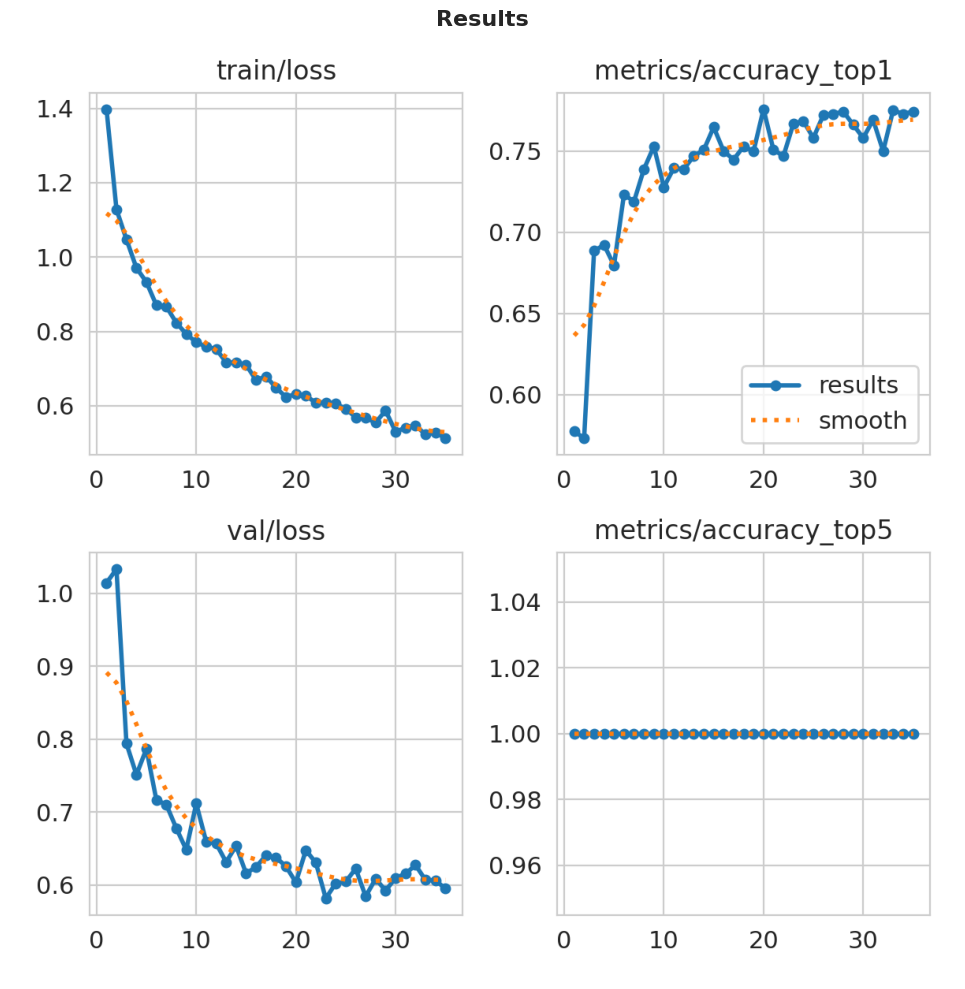

✓ results.png


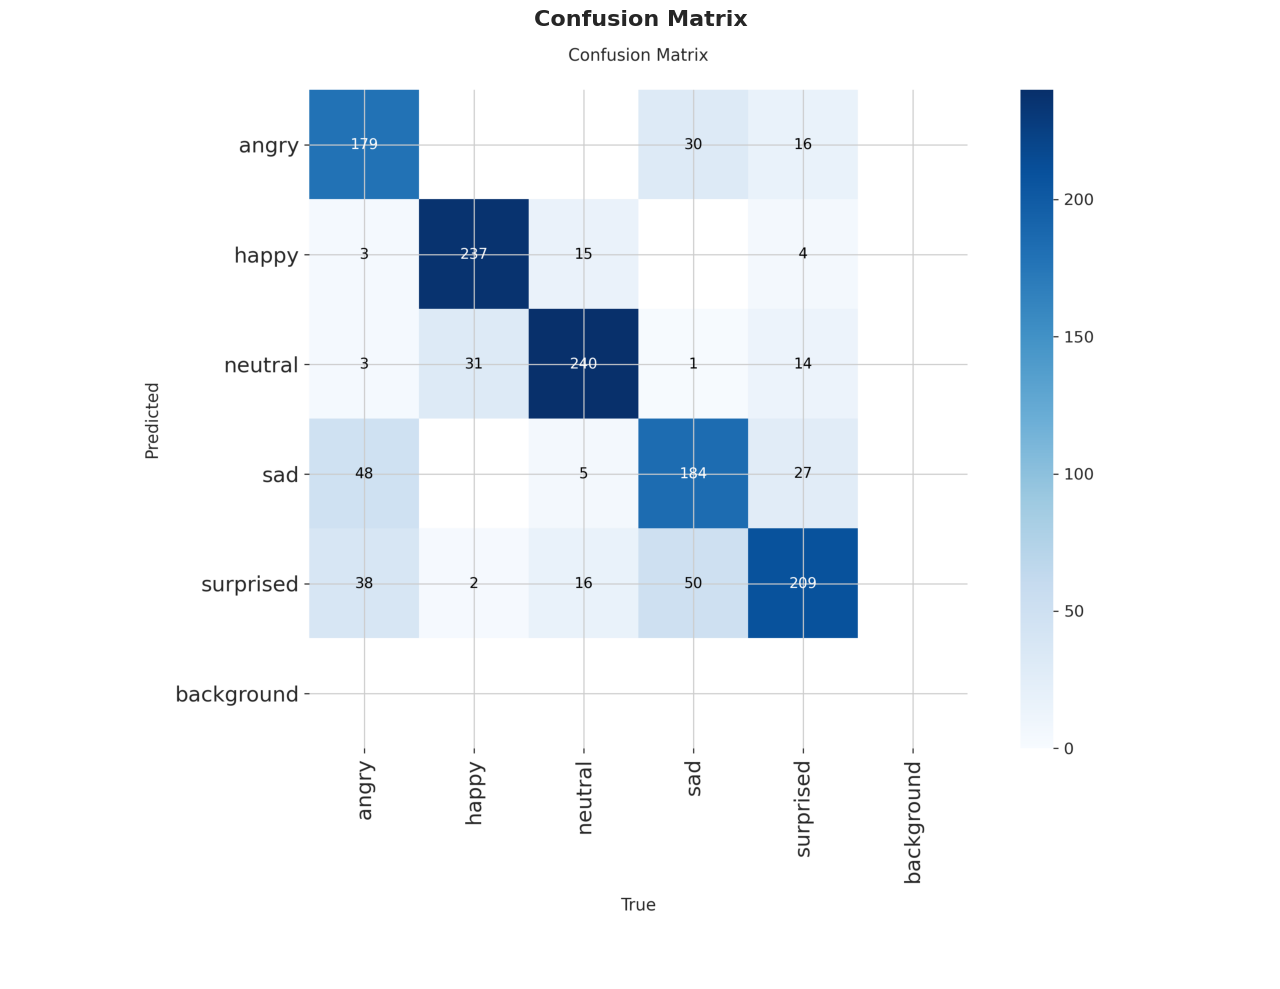

✓ confusion_matrix.png


In [19]:
# Display training results
print("=" * 60)
print("TRAINING RESULTS")
print("=" * 60)

# Find and display generated plots
plot_dir = os.path.join(OUTPUT_DIR, 'fer_yolov8')

plots_to_show = ['results.png', 'confusion_matrix.png']

for plot_name in plots_to_show:
    plot_path = os.path.join(plot_dir, plot_name)
    if os.path.exists(plot_path):
        img = Image.open(plot_path)
        plt.figure(figsize=(14, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(plot_name.replace('.png', '').replace('_', ' ').title(), fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print(f"✓ {plot_name}")
    else:
        print(f"⚠ {plot_name} not found")

print("=" * 60)

## 🔟 Validate Model on Test Set

In [20]:
print("=" * 60)
print("EVALUATING ON TEST SET")
print("=" * 60)

# Load best model
best_model_path = os.path.join(OUTPUT_DIR, 'fer_yolov8', 'weights', 'best.pt')
best_model = YOLO(best_model_path)

# Validate on test set
print("Running validation on test set...")
metrics = best_model.val(
    data=yolo_dataset_dir,
    split='test',
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE
)

print("\n" + "=" * 60)
print("TEST SET METRICS")
print("=" * 60)
print(f"✓ Top-1 Accuracy: {metrics.top1:.4f} ({metrics.top1*100:.2f}%)")
print(f"✓ Top-5 Accuracy: {metrics.top5:.4f} ({metrics.top5*100:.2f}%)")
print("=" * 60)

EVALUATING ON TEST SET
Running validation on test set...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,441,285 parameters, 0 gradients, 3.3 GFLOPs
train: /content/output/yolo_fer_dataset/train... found 4913 images in 5 classes ✅ 
val: /content/output/yolo_fer_dataset/val... found 1352 images in 5 classes ✅ 
test: /content/output/yolo_fer_dataset/test... found 756 images in 5 classes ✅ 
test: Fast image access ✅ (ping: 0.0±0.0 ms, read: 230.3±88.0 MB/s, size: 4.8 KB)
test: Scanning /content/output/yolo_fer_dataset/test... 756 images, 0 corrupt: 100% ━━━━━━━━━━━━ 756/756 6.1Kit/s 0.1s
test: New cache created: /content/output/yolo_fer_dataset/test.cache
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 48/48 46.0it/s 1.0s
                   all      0.806          1
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val

TEST S

### Detailed Per-Class Evaluation

In [21]:
# Get detailed per-class predictions
print("Running detailed evaluation...")

y_true = []
y_pred = []

for class_name in CLASS_NAMES:
    class_dir = os.path.join(yolo_test_dir, class_name)
    if not os.path.exists(class_dir):
        continue

    class_idx = CLASS_NAMES.index(class_name)
    img_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Processing {class_name}: {len(img_files)} images...")

    for img_file in img_files:
        img_path = os.path.join(class_dir, img_file)

        # Predict
        results = best_model(img_path, verbose=False)

        if len(results) > 0:
            probs = results[0].probs.data.cpu().numpy()
            pred_idx = probs.argmax()

            y_true.append(class_idx)
            y_pred.append(pred_idx)

# Convert to numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

# Overall accuracy
accuracy = np.mean(y_pred == y_true)
print(f"{'=' * 60}")
print(f"OVERALL TEST ACCURACY: {accuracy*100:.2f}%")
print(f"{'=' * 60}")

Running detailed evaluation...
Processing angry: 152 images...
Processing happy: 150 images...
Processing neutral: 158 images...
Processing sad: 146 images...
Processing surprised: 150 images...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry     0.8372    0.7105    0.7687       152
       happy     0.9571    0.8933    0.9241       150
     neutral     0.8808    0.8418    0.8608       158
         sad     0.7000    0.7671    0.7320       146
   surprised     0.6932    0.8133    0.7485       150

    accuracy                         0.8056       756
   macro avg     0.8137    0.8052    0.8068       756
weighted avg     0.8150    0.8056    0.8077       756

OVERALL TEST ACCURACY: 80.56%


### Confusion Matrix Visualization

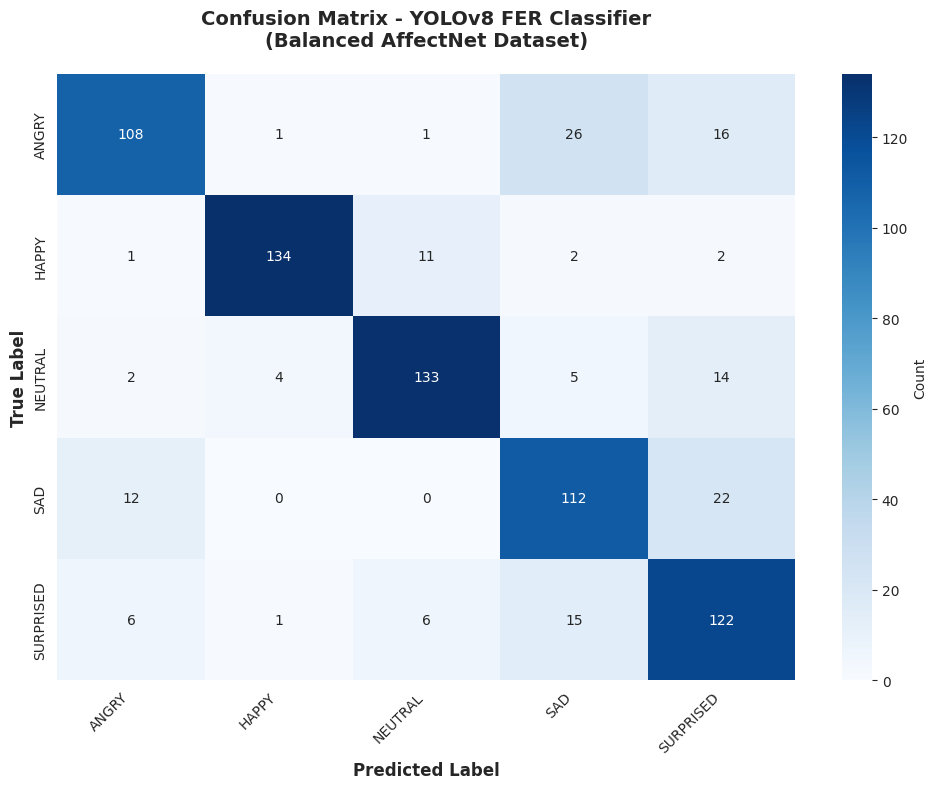

Saved: /content/output/confusion_matrix_yolov8.png


In [22]:
# Create confusion matrix visualization
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[c.upper() for c in CLASS_NAMES],
    yticklabels=[c.upper() for c in CLASS_NAMES],
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - YOLOv8 FER Classifier\n(Balanced AffectNet Dataset)',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save
cm_path = os.path.join(OUTPUT_DIR, 'confusion_matrix_yolov8.png')
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {cm_path}")

## 1️⃣1️⃣ Export Model for Deployment

In [23]:
print("=" * 60)
print("EXPORTING MODELS FOR DEPLOYMENT")
print("=" * 60)

# 1. Copy best PyTorch model
pt_path = os.path.join(OUTPUT_DIR, 'fer_yolov8_cls_best.pt')
shutil.copy2(best_model_path, pt_path)
pt_size = os.path.getsize(pt_path) / (1024 * 1024)
print(f"✓ PyTorch model: {pt_path}")
print(f"  Size: {pt_size:.2f} MB")

# 2. Export to ONNX (for Raspberry Pi with ONNX Runtime)
print("\nExporting to ONNX...")
best_model.export(format='onnx', imgsz=IMG_SIZE, simplify=True)

# Find and copy ONNX file
onnx_src = os.path.join(OUTPUT_DIR, 'fer_yolov8', 'weights', 'best.onnx')
onnx_dst = os.path.join(OUTPUT_DIR, 'fer_yolov8_cls.onnx')

if os.path.exists(onnx_src):
    shutil.copy2(onnx_src, onnx_dst)
    onnx_size = os.path.getsize(onnx_dst) / (1024 * 1024)
    print(f"✓ ONNX model: {onnx_dst}")
    print(f"  Size: {onnx_size:.2f} MB")

# 3. Try TFLite export (optional)
print("\nExporting to TFLite...")
try:
    best_model.export(format='tflite', imgsz=IMG_SIZE)

    # Find TFLite file
    for root, dirs, files in os.walk(os.path.join(OUTPUT_DIR, 'fer_yolov8')):
        for file in files:
            if file.endswith('.tflite'):
                tflite_src = os.path.join(root, file)
                tflite_dst = os.path.join(OUTPUT_DIR, 'fer_yolov8_cls.tflite')
                shutil.copy2(tflite_src, tflite_dst)
                tflite_size = os.path.getsize(tflite_dst) / (1024 * 1024)
                print(f"✓ TFLite model: {tflite_dst}")
                print(f"  Size: {tflite_size:.2f} MB")
                break
except Exception as e:
    print(f"⚠ TFLite export failed: {e}")
    print("  Use ONNX format for Raspberry Pi instead")

print("\n" + "=" * 60)
print("EXPORT COMPLETE")
print("=" * 60)
print("\nFiles ready for download:")
print(f"  📦 fer_yolov8_cls_best.pt  (PyTorch)")
print(f"  📦 fer_yolov8_cls.onnx     (ONNX - recommended for Pi)")
print(f"  📦 confusion_matrix_yolov8.png")
print("=" * 60)

EXPORTING MODELS FOR DEPLOYMENT
✓ PyTorch model: /content/output/fer_yolov8_cls_best.pt
  Size: 2.83 MB

Exporting to ONNX...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/output/fer_yolov8/weights/best.pt' with input shape (1, 3, 96, 96) BCHW and output shape(s) (1, 5) (2.8 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 208ms
Prepared 6 packages in 6.27s
Installed 6 packages in 255ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.78

requirements: AutoUpdate success ✅ 7.4s
WARNING ⚠️ requirements: Restart runtime or rerun command for up

## 1️⃣2️⃣ Test ONNX Model Inference

In [24]:
# Create a ZIP file with all models for easy download
import zipfile

print("=" * 60)
print("CREATING DOWNLOAD PACKAGE")
print("=" * 60)

# Files to include in download package
download_files = [
    ('fer_yolov8_cls_best.pt', 'PyTorch model'),
    ('fer_yolov8_cls.onnx', 'ONNX model (for Raspberry Pi)'),
    ('confusion_matrix_yolov8.png', 'Confusion matrix'),
]

# Create ZIP file
zip_path = os.path.join(OUTPUT_DIR, 'fer_models_download.zip')

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for filename, desc in download_files:
        filepath = os.path.join(OUTPUT_DIR, filename)
        if os.path.exists(filepath):
            zipf.write(filepath, filename)
            size_mb = os.path.getsize(filepath) / (1024 * 1024)
            print(f"  Added: {filename} ({size_mb:.2f} MB) - {desc}")
        else:
            print(f"  Not found: {filename}")

zip_size = os.path.getsize(zip_path) / (1024 * 1024)
print(f"\n📦 ZIP created: {zip_path}")
print(f"   Size: {zip_size:.2f} MB")

# List all output files
print("\n" + "=" * 60)
print("ALL OUTPUT FILES")
print("=" * 60)

for f in sorted(os.listdir(OUTPUT_DIR)):
    fpath = os.path.join(OUTPUT_DIR, f)
    if os.path.isfile(fpath):
        size = os.path.getsize(fpath) / (1024 * 1024)
        print(f"  {f} ({size:.2f} MB)")

print("\n" + "=" * 60)

# Trigger download of ZIP file
from google.colab import files
print("\nDownloading ZIP file...")
files.download(zip_path)

CREATING DOWNLOAD PACKAGE
  Added: fer_yolov8_cls_best.pt (2.83 MB) - PyTorch model
  Added: fer_yolov8_cls.onnx (5.53 MB) - ONNX model (for Raspberry Pi)
  Added: confusion_matrix_yolov8.png (0.08 MB) - Confusion matrix

📦 ZIP created: /content/output/fer_models_download.zip
   Size: 7.57 MB

ALL OUTPUT FILES
  confusion_matrix_yolov8.png (0.08 MB)
  fer_models_download.zip (7.57 MB)
  fer_yolov8_cls.onnx (5.53 MB)
  fer_yolov8_cls.tflite (2.78 MB)
  fer_yolov8_cls_best.pt (2.83 MB)




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## ✅ Training Complete!

### What Was Done:
1. ✅ Mounted Google Drive for dataset access
2. ✅ Loaded **Balanced AffectNet** (75×75 RGB, ~25k images)
3. ✅ Added **Custom Dataset** (100-200 images per class)
4. ✅ Merged and resized all images to **224×224**
5. ✅ Trained **YOLOv8n-cls** for 50 epochs (~20-30 min)
6. ✅ Evaluated with confusion matrix
7. ✅ Exported to **ONNX** for Raspberry Pi

### Output Files:
| File | Format | Use |
|------|--------|-----|
| `fer_yolov8_cls_best.pt` | PyTorch | Backup/retraining |
| `fer_yolov8_cls.onnx` | ONNX | **Raspberry Pi deployment** |
| `confusion_matrix_yolov8.png` | Image | Report |

### Next Steps:
1. **Download** `fer_yolov8_cls.onnx` from `/content/output/`
2. **Or copy to Drive**: `!cp /content/output/fer_yolov8_cls.onnx /content/drive/MyDrive/`
3. **Copy** to your project: `fer_model/fer_classifier_yolo.onnx`
4. **Run** the robot pipeline: `python main_yolo.py`

### Dataset Summary:
- **AffectNet**: ~25,000 images (5 classes)
- **Custom**: ~500-1000 images (your data)
- **Total**: ~25,500-26,000 images

### Emotion → Robot Action:
| Emotion | Robot Action |
|---------|--------------|
| Happy | Move Forward |
| Angry | Move Backward |
| Surprised | Turn Left |
| Sad | Turn Right |
| Neutral | Stop |

---
**🎉 Your FER model (trained on Google Colab) is ready!**